In [1]:
# Load dependencies and mat.-files

from src import RelErrorTracker
import scipy.sparse.linalg as spla
import scipy.sparse as sp
import numpy as np
import scipy.io
import time
from matplotlib import pyplot as plt
import ilupp
from scipy.sparse.linalg import spsolve

mat = scipy.io.loadmat('../data/cooling_flange.mat')
A = mat["A"]
np.random.seed(0)
b = np.random.rand(A.shape[0])

### Display sparsity

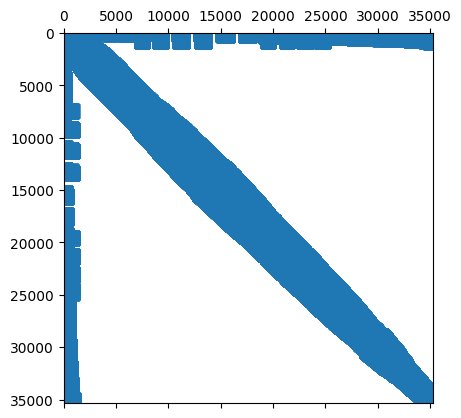

In [3]:
plt.spy(A)

### Linear (sparse) Solver:

In [2]:
t = time.time()
x_ls = spla.spsolve(A,b, use_umfpack=False)
dt = time.time() - t
print(f"Computation time linear solver: {dt} seconds. Relative error: {np.linalg.norm(A*x_ls-b)/np.linalg.norm(b)}")

Computation time linear solver: 8.380221128463745 seconds. Relative error: 3.674741532018247e-12


### Regular Conjugate Gradient:

In [4]:
relerror = 1e-4


t = time.time()
x_cg = spla.cg(A, b, tol = relerror)[0]
dt = time.time() - t
print(f"Computation time conjugate gradient: {dt} seconds. Relative error: {np.linalg.norm(A*x_cg-b)/np.linalg.norm(b)}")

# Additional run to measure convergence:
relerr_cg = RelErrorTracker(A,b)
_ = spla.cg(A, b, tol = relerror, callback = relerr_cg.callback)[0]

Computation time conjugate gradient: 2.019465923309326 seconds. Relative error: 9.872394806435437e-05


### PCG (M: diag)

In [5]:
M = sp.diags(A.diagonal()**(-1))
t = time.time()
x_pcgd = spla.cg(A, b, tol = relerror, M = M)[0]
dt = time.time() - t

print(f"Computation time preconditioned conjugate gradient: {dt} seconds. Relative error: {np.linalg.norm(A*x_pcgd-b)/np.linalg.norm(b)}")

# Additional run to measure convergence:
relerr_pcgd = RelErrorTracker(A,b)
_ = spla.cg(A, b, tol = relerror, M = M, callback=relerr_pcgd.callback)[0]

Computation time preconditioned conjugate gradient: 1.6316652297973633 seconds. Relative error: 9.826061452207157e-05


### PCG (M: ichol)

In [6]:
M = ilupp.IChol0Preconditioner(sp.csr_matrix(A))
t = time.time()
x_pcgc = spla.cg(A, b, tol = relerror, M = M)[0]
dt = time.time() - t
print(f"Computation time preconditioned conjugate gradient: {dt} seconds. Relative error: {np.linalg.norm(A*x_pcgc-b)/np.linalg.norm(b)}")


# Additional run to measure convergence:
relerr_pcgc = RelErrorTracker(A,b)
_ = spla.cg(A, b, tol = relerror, M = M, callback=relerr_pcgc.callback)[0]

Computation time preconditioned conjugate gradient: 0.6754868030548096 seconds. Relative error: 9.159568995576646e-05


### Compare plots

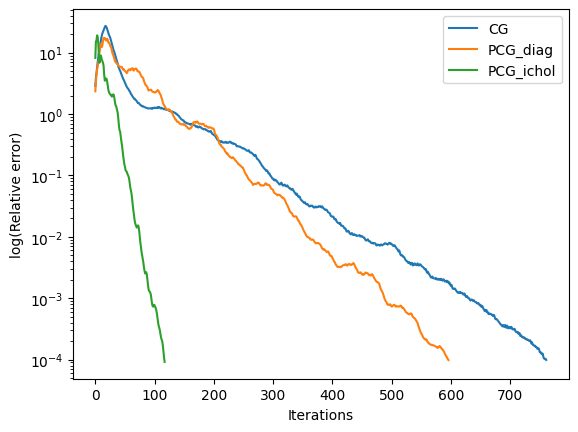

In [7]:
plt.semilogy(relerr_cg.norms)
plt.semilogy(relerr_pcgd.norms)
plt.semilogy(relerr_pcgc.norms)
plt.xlabel("Iterations")
plt.ylabel("log(Relative error)")
plt.legend(["CG","PCG_diag","PCG_ichol"])
plt.show()

### Part c

In [8]:
# Load mat.-files and display sparsity
mat = scipy.io.loadmat('../data/convdiff.mat')
A = mat["A"]
np.random.seed(4)
b = np.random.rand(A.shape[0])

### Display sparsity

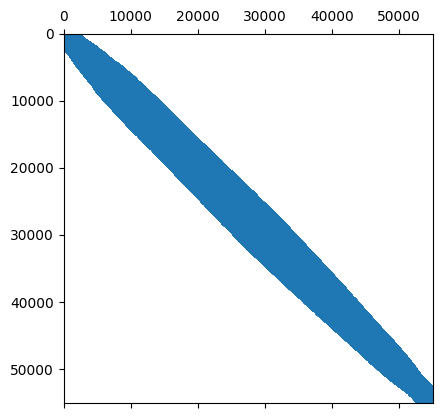

In [9]:
plt.spy(A)

### Linear (sparse) solver

In [3]:
# Linear solver:
t = time.time()
x = spsolve(A,b, use_umfpack=False)
dt = time.time() - t
print(f"Computation time linear solver: {dt} seconds. Relative error: {np.linalg.norm(A*x-b)/np.linalg.norm(b)}")

Computation time linear solver: 37.79218101501465 seconds. Relative error: 6.070305104334279e-12


#### GMRES with preconditioner:

In [9]:
M = ilupp.ILUTPreconditioner(sp.csr_matrix(A))
relerror = 1e-4

t = time.time()
x_gm = spla.gmres(A, b, tol = relerror, M=M, maxiter=3000)[0]
dt = time.time() - t
print(f"Computation time preconditioned gmres: {dt} seconds. Relative error: {np.linalg.norm(A*x_gm-b)/np.linalg.norm(b)}")


# Additional run to measure convergence:
relerr_gm = RelErrorTracker(A,b)
_ = spla.gmres(A, b, tol = relerror, M=M, callback=relerr_gm.callback, callback_type='x', maxiter=3000)[0]

Computation time preconditioned gmres: 1.929473876953125 seconds. Relative error: 2.9839484297043237e-05


#### GMRES without preconditioner:

In [5]:
t = time.time()
x_gm_without = spla.gmres(A, b, tol = relerror, maxiter=3000)[0]
dt = time.time() - t
print(f"Computation time gmres: {dt} seconds. Relative error: {np.linalg.norm(A*x_gm_without-b)/np.linalg.norm(b)}")

# Additional run to measure convergence:
relerr_gm_without = RelErrorTracker(A,b)
_ = spla.gmres(A, b, tol = relerror, callback=relerr_gm_without.callback, callback_type = "x", maxiter=3000)[0]

Computation time gmres: 8.440690040588379 seconds. Relative error: 9.949291983726468e-05


## Compare plots GMRES

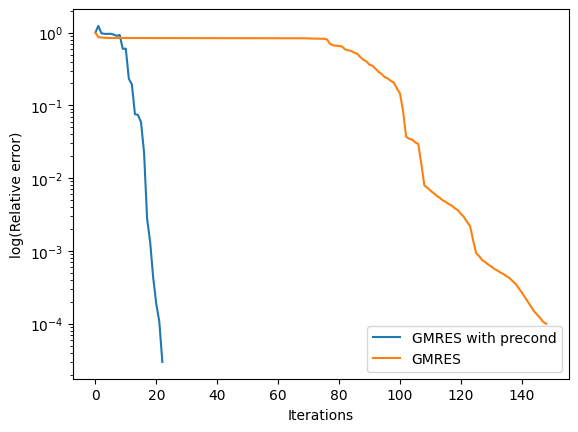

In [15]:
plt.semilogy(relerr_gm.norms)
plt.semilogy(relerr_gm_without.norms)
plt.xlabel("Iterations")
plt.ylabel("Relative error")
plt.legend(["GMRES with precond","GMRES"])
plt.show()

### Using the package "ilupp"

In [10]:
t = time.time()
x_ilupp, info = ilupp.solve(sp.csr_matrix(A),b, info = True, rtol = relerror)
dt = time.time() - t
print(f"Computation time using ilupp: {dt} seconds. Relative error: {np.linalg.norm(A*x_ilupp-b)/np.linalg.norm(b)}")
print(f"ILUPP converged at {info[0]} iterations")

Computation time using ilupp: 1.0023281574249268 seconds. Relative error: 5.970692454008197e-07
ILUPP converged at 117 iterations
